# Ma, et al. 2006 - Bayesian inference with Probabilistic Population Codes

In [1]:
import torch, math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from purias_utils.population.stimuli import VectorisedStimulusBasisFunctionSet
from purias_utils.population.neurons import AngularThresholdedTuningCurve, IndependentPoissonPopulationResponse

from purias_utils.util.array import gaussian_on_a_circle

#### Populations with proportional tuning curves forms

(0.0, 20.0)

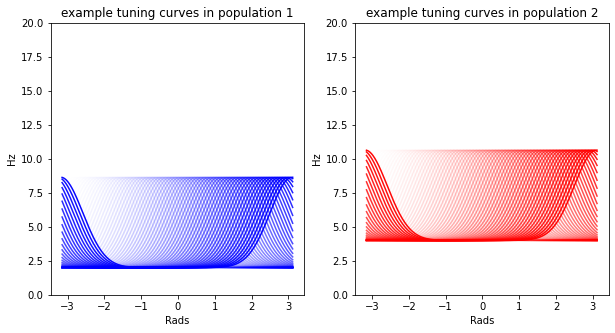

In [2]:
num_bins = 361
all_bins = torch.arange(-num_bins//2, num_bins//2)

diff = math.pi / num_bins     # only works for odd bins!
mean_bins = torch.arange(-num_bins//2, num_bins//2, 5)
std_angles = torch.ones_like(mean_bins) * 0.6
scales = 10 * torch.ones_like(mean_bins)

thresholds_1 = [-2]
thresholds_2 = [-4]

tuning_curve_vectors = gaussian_on_a_circle(num_bins, mean_bins, std_angles, scales)

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].set_title('example tuning curves in population 1')
axes[1].set_title('example tuning curves in population 2')
[ax.set_ylabel('Hz') for ax in axes]
[ax.set_xlabel('Rads') for ax in axes]

viz_spacing = 1

for i, tcvn in enumerate(tuning_curve_vectors[::viz_spacing]):
    axes[0].plot(all_bins * (2 * math.pi) / (num_bins), torch.relu(tcvn - thresholds_1[0]).numpy(), alpha=(viz_spacing * i/len(tuning_curve_vectors))**2, color="blue")

for i, tcvn in enumerate(tuning_curve_vectors[::viz_spacing]):
    axes[1].plot(all_bins * (2 * math.pi) / (num_bins), torch.relu(tcvn - thresholds_2[0]).numpy(), alpha=(viz_spacing * i/len(tuning_curve_vectors))**2, color="red")


tuning_curves_1 = AngularThresholdedTuningCurve(tuning_curve_vectors, thresholds = thresholds_1)
population_1 = IndependentPoissonPopulationResponse([tuning_curves_1])

tuning_curves_2 = AngularThresholdedTuningCurve(tuning_curve_vectors, thresholds = thresholds_2)
population_2 = IndependentPoissonPopulationResponse([tuning_curves_2])

axes[0].set_ylim(0, 20)
axes[1].set_ylim(0, 20)

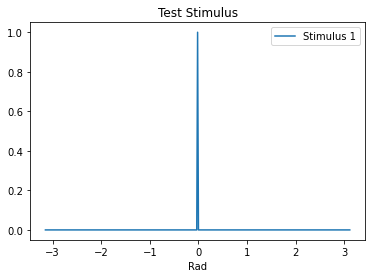

In [3]:
m_basis_vectors  = torch.zeros(num_bins, 2)
m_basis_vectors[num_bins//2, 0] = 1.0
m_basis_vectors[num_bins//3, 1] = 1.0

m_basis = VectorisedStimulusBasisFunctionSet(m_basis_vectors)

stim_1 = m_basis.multiplicative_stimulus(torch.tensor([[1., 0.]]))
stim_2 = m_basis.multiplicative_stimulus(torch.tensor([[0., 1.]]))

theta = all_bins * (2 * math.pi) / (num_bins)

fig, axes = plt.subplots(1)
axes.plot(theta.numpy(), stim_1[0].numpy(), label = 'Stimulus 1')
# axes.plot(theta.numpy(), stim_2[0].numpy(), label = 'Stimulus 2')

axes.set_title('Test Stimulus')
axes.set_xlabel('Rad')

axes.legend()

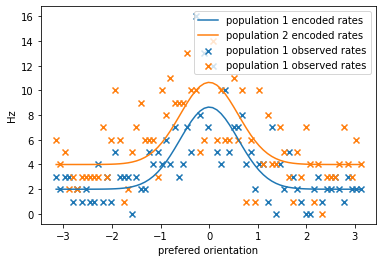

In [33]:
encoded_rates_1 = population_1.population_mean_firing_rate(stim_1)
encoded_rates_2 = population_2.population_mean_firing_rate(stim_1)

duration = 1.
real_rates_1 = population_1.empirical_rates_from_encoded_rates(encoded_rates_1, duration)
real_rates_2 = population_2.empirical_rates_from_encoded_rates(encoded_rates_2, duration)


fig, axes = plt.subplots(1)

axes.plot(mean_bins* (2 * math.pi) / (num_bins), encoded_rates_1[0], label = 'population 1 encoded rates')
axes.plot(mean_bins* (2 * math.pi) / (num_bins), encoded_rates_2[0], label = 'population 2 encoded rates')

axes.scatter(mean_bins* (2 * math.pi) / (num_bins), real_rates_1[0], marker='x', label = 'population 1 observed rates')
axes.scatter(mean_bins* (2 * math.pi) / (num_bins), real_rates_2[0], marker='x', label = 'population 1 observed rates')

axes.set_ylabel('Hz')
axes.set_xlabel('prefered orientation')
axes.legend()

The above figure substitutes the **left hand side of figure 1A and 1B**, i.e. activity against P.O.

To get the right hand column, we need to get the Poisson likelihoods from these rates, scale them to a posterior, then approximate them to a Gaussian

Text(0.5, 0.98, 'Normal approximation fits independent Poisson liklihoods well')

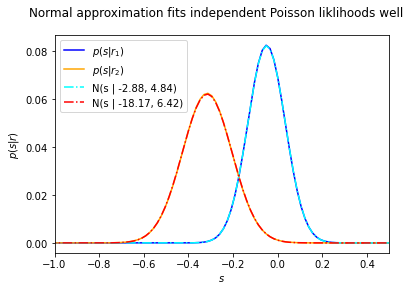

In [35]:
import torch

def gaussian_pdf(value, std=1.0, mean=0.0):
    var = (std ** 2)
    log_scale = math.log(std)
    return np.exp(-((value - mean) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi)))

def normalise_log_likelihoods(llh_vector):
    assert len(llh_vector.shape) == 1
    lh_vector = torch.exp(llh_vector - llh_vector.max())
    return lh_vector / lh_vector.sum()

all_possible_responses_1 = population_1.population_mean_firing_rate(torch.eye(num_bins))
poisson_llh_1 = population_1.rate_loglikelihoods(real_rates_1, all_possible_responses_1, duration).sum(-1)
posterior_1 = normalise_log_likelihoods(poisson_llh_1)

all_possible_responses_2 = population_2.population_mean_firing_rate(torch.eye(num_bins))
poisson_llh_2 = population_2.rate_loglikelihoods(real_rates_2, all_possible_responses_2, duration).sum(-1)
posterior_2 = normalise_log_likelihoods(poisson_llh_2)


posterior_mean_1 = (posterior_1 * all_bins).sum()
posterior_std_1 = (posterior_1 * (all_bins - posterior_mean_1)**2).sum() ** 0.5
posterior_1_approx = gaussian_pdf(all_bins, posterior_std_1, posterior_mean_1)

posterior_mean_2 = (posterior_2 * all_bins).sum()
posterior_std_2 = (posterior_2 * (all_bins - posterior_mean_2)**2).sum() ** 0.5
posterior_2_approx = gaussian_pdf(all_bins, posterior_std_2, posterior_mean_2)


fig, axes = plt.subplots(1)

axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_1, color='blue', label = '$p(s|r_1)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_2, color='orange', label = '$p(s|r_2)$')

axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_1_approx, linestyle='-.', color='cyan', label = f'N(s | {round(posterior_mean_1.item(), 2)}, {round(posterior_std_1.item(), 2)})')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_2_approx, linestyle='-.', color='red', label = f'N(s | {round(posterior_mean_2.item(), 2)}, {round(posterior_std_2.item(), 2)})')

axes.set_ylabel('$p(s|r)$')
axes.set_xlabel('$s$')
axes.legend()

axes.set_xlim(-1.0, 0.5)

fig.suptitle('Normal approximation fits independent Poisson liklihoods well')

There are now three 'methods' to combining the posteriors above

1. Analytically, as a target to compare to
2. By adding encoded rates and renormalising again
3. By adding observed rates and approximating

Method 1: ideal bayesian case is analytical

(-1.0, 0.5)

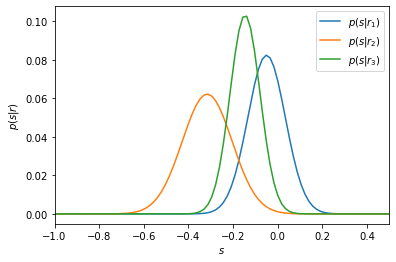

In [37]:
posterior_mean_3 = (posterior_mean_2 * posterior_std_1**2 + posterior_mean_1 * posterior_std_2**2) / (posterior_std_1**2 + posterior_std_2**2)
posterior_std_3 = 1 / (posterior_std_1**-2 + posterior_std_2**-2) ** 0.5
posterior_3_approx = gaussian_pdf(all_bins, posterior_std_3, posterior_mean_3)

fig, axes = plt.subplots(1)

axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_1_approx, label = '$p(s|r_1)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_2_approx, label = '$p(s|r_2)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_3_approx, label = '$p(s|r_3)$')

axes.set_ylabel('$p(s|r)$')
axes.set_xlabel('$s$')
axes.legend()

axes.set_xlim(-1, 0.5)

Method 2: Adding rates case - we take rate loglikelihood with respect to the tuning curve of the 'presynaptic' population (threshold doesn't matter here, so we can choose either one)

(-1.0, 0.5)

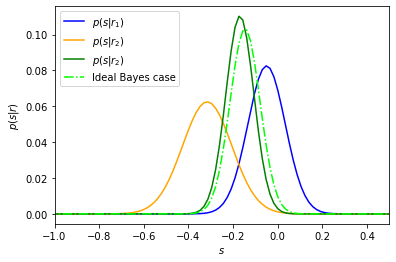

In [39]:
real_rates_3 = real_rates_1 + real_rates_2

all_possible_responses_3 = population_1.population_mean_firing_rate(torch.eye(num_bins))
poisson_llh_3 = population_1.rate_loglikelihoods(real_rates_3, all_possible_responses_3, duration).sum(-1)
poisson_lh_3 = torch.exp(poisson_llh_3 - poisson_llh_3.max())
posterior_3 = poisson_lh_3 / poisson_lh_3.sum()

fig, axes = plt.subplots(1)

axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_1, color='blue', label = '$p(s|r_1)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_2, color='orange', label = '$p(s|r_2)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_3, color='green', label = '$p(s|r_2)$')
axes.plot(all_bins * (2 * math.pi) / (num_bins), posterior_3_approx, linestyle='-.', color='lime', label = 'Ideal Bayes case')

axes.set_ylabel('$p(s|r)$')
axes.set_xlabel('$s$')
axes.legend()

axes.set_xlim(-1, 0.5)

TODO: find out why there is a descrepency here, this should be much closer I think!

#### Populations with different tuning curves forms (and different population sizes)

In [40]:


class GeneralisedPopulationResponse(IndependentPoissonPopulationResponse):
    """
    TODO: REVERSE INHERITANCE DIRECTION AND MAKE POISSON CLASS SUPPLY STATISTICS TO THIS CLASS
    """




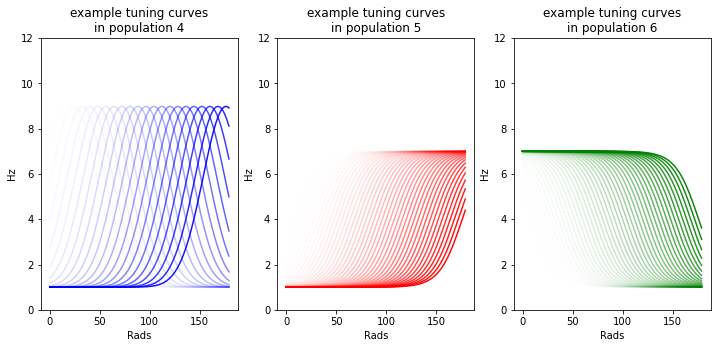

In [41]:
from torch import Tensor as T

def sigmoid_on_a_circle(num_bins: int, half_points: T, divisors: T, scales: T):

    assert half_points.shape == divisors.shape == scales.shape
    assert len(half_points.shape) == 1

    num_bumps = half_points.shape[0]
    theta = torch.linspace(-math.pi, math.pi, num_bins).unsqueeze(0).repeat(num_bumps, 1)

    sigmoids = torch.sigmoid(theta / divisors.unsqueeze(1))

    for i in range(sigmoids.shape[0]):
        rolled = torch.roll(sigmoids[i], half_points[i].item())
        sigmoids[i] = scales[i] * rolled

    return sigmoids


gaussian_mean_bins = torch.arange(-90, 90, 8)
std_angles = torch.ones_like(gaussian_mean_bins) * 0.4
gaussian_scales = 8 * torch.ones_like(gaussian_mean_bins)
tuning_curve_vectors_4 = gaussian_on_a_circle(num_bins, gaussian_mean_bins, std_angles, gaussian_scales)

sigmoid_mean_bins = torch.arange(-90, 90, 4)
divisors = torch.ones(len(sigmoid_mean_bins)) / 5
scales = torch.ones(len(sigmoid_mean_bins)) * 6
sigmoidal_tuning_curve_vectors_1 = sigmoid_on_a_circle(num_bins, sigmoid_mean_bins, divisors, scales)
sigmoidal_tuning_curve_vectors_2 = sigmoid_on_a_circle(num_bins, sigmoid_mean_bins, - divisors, scales)


tuning_curve_vectors_4 = tuning_curve_vectors_4[:,90:270]
sigmoidal_tuning_curve_vectors_1 = sigmoidal_tuning_curve_vectors_1[:,90:270]
sigmoidal_tuning_curve_vectors_2 = sigmoidal_tuning_curve_vectors_2[:,90:270]

tuning_curves_4 = AngularThresholdedTuningCurve(tuning_curve_vectors_4, thresholds = [-1])
population_4 = GeneralisedPopulationResponse([tuning_curves_4])

tuning_curves_5 = AngularThresholdedTuningCurve(sigmoidal_tuning_curve_vectors_1, thresholds = [-1])
population_5 = GeneralisedPopulationResponse([tuning_curves_5])

tuning_curves_6 = AngularThresholdedTuningCurve(sigmoidal_tuning_curve_vectors_2, thresholds = [-1])
population_6 = GeneralisedPopulationResponse([tuning_curves_6])



fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].set_title('example tuning curves\nin population 4')
axes[1].set_title('example tuning curves\nin population 5')
axes[2].set_title('example tuning curves\nin population 6')
[ax.set_ylabel('Hz') for ax in axes]
[ax.set_xlabel('Rads') for ax in axes]
[ax.set_ylim(0, 12) for ax in axes]

viz_spacing = 1

for i, tcvn in enumerate(tuning_curve_vectors_4[::viz_spacing]):
    axes[0].plot(torch.relu(tcvn + 1).numpy(), alpha=(viz_spacing * i/len(tuning_curve_vectors_4))**2, color="blue")

for i, tcvn in enumerate(sigmoidal_tuning_curve_vectors_1[::viz_spacing]):
    axes[1].plot(torch.relu(tcvn + 1).numpy(), alpha=(viz_spacing * i/len(sigmoidal_tuning_curve_vectors_1))**2, color="red")

for i, tcvn in enumerate(sigmoidal_tuning_curve_vectors_2[::viz_spacing]):
    axes[2].plot(torch.relu(tcvn + 1).numpy(), alpha=(viz_spacing * i/len(sigmoidal_tuning_curve_vectors_2))**2, color="green")

new_stim = stim_1[:,90:270]

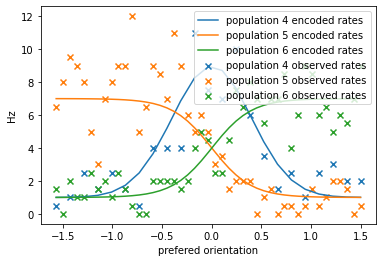

In [42]:
stim_2 = stim_1[:,90:270]

encoded_rates_4 = population_4.population_mean_firing_rate(stim_2)
encoded_rates_5 = population_5.population_mean_firing_rate(stim_2)
encoded_rates_6 = population_6.population_mean_firing_rate(stim_2)

duration = 2.
real_rates_4 = population_4.empirical_rates_from_encoded_rates(encoded_rates_4, duration)
real_rates_5 = population_5.empirical_rates_from_encoded_rates(encoded_rates_5, duration)
real_rates_6 = population_6.empirical_rates_from_encoded_rates(encoded_rates_6, duration)


fig, axes = plt.subplots(1)

axes.plot(gaussian_mean_bins* (2 * math.pi) / (num_bins), encoded_rates_4[0], label = 'population 4 encoded rates')
axes.plot(sigmoid_mean_bins* (2 * math.pi) / (num_bins), encoded_rates_5[0], label = 'population 5 encoded rates')
axes.plot(sigmoid_mean_bins* (2 * math.pi) / (num_bins), encoded_rates_6[0], label = 'population 6 encoded rates')

axes.scatter(gaussian_mean_bins* (2 * math.pi) / (num_bins), real_rates_4[0], marker='x', label = 'population 4 observed rates')
axes.scatter(sigmoid_mean_bins* (2 * math.pi) / (num_bins), real_rates_5[0], marker='x', label = 'population 5 observed rates')
axes.scatter(sigmoid_mean_bins* (2 * math.pi) / (num_bins), real_rates_6[0], marker='x', label = 'population 6 observed rates')

axes.set_ylabel('Hz')
axes.set_xlabel('prefered orientation')
axes.legend()

Text(0.5, 0.98, 'Normal approximation fits independent Poisson liklihoods well')

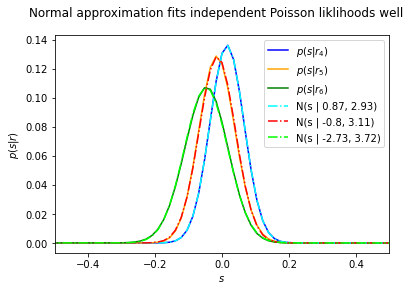

In [43]:
all_possible_responses_4 = population_4.population_mean_firing_rate(torch.eye(population_4.stimulus_dimension))
poisson_llh_4 = population_4.rate_loglikelihoods(real_rates_4, all_possible_responses_4, duration).sum(-1)
posterior_4 = normalise_log_likelihoods(poisson_llh_4)

all_possible_responses_5 = population_5.population_mean_firing_rate(torch.eye(population_5.stimulus_dimension))
poisson_llh_5 = population_5.rate_loglikelihoods(real_rates_5, all_possible_responses_5, duration).sum(-1)
posterior_5 = normalise_log_likelihoods(poisson_llh_5)

all_possible_responses_6 = population_6.population_mean_firing_rate(torch.eye(population_6.stimulus_dimension))
poisson_llh_6 = population_6.rate_loglikelihoods(real_rates_6, all_possible_responses_6, duration).sum(-1)
posterior_6 = normalise_log_likelihoods(poisson_llh_6)


all_bins_new = all_bins[90:270]

posterior_mean_4 = (posterior_4 * all_bins_new).sum()
posterior_std_4 = (posterior_4 * (all_bins_new - posterior_mean_4)**2).sum() ** 0.5
posterior_4_approx = gaussian_pdf(all_bins_new, posterior_std_4, posterior_mean_4)

posterior_mean_5 = (posterior_5 * all_bins_new).sum()
posterior_std_5 = (posterior_5 * (all_bins_new - posterior_mean_5)**2).sum() ** 0.5
posterior_5_approx = gaussian_pdf(all_bins_new, posterior_std_5, posterior_mean_5)

posterior_mean_6 = (posterior_6 * all_bins_new).sum()
posterior_std_6 = (posterior_6 * (all_bins_new - posterior_mean_6)**2).sum() ** 0.5
posterior_6_approx = gaussian_pdf(all_bins_new, posterior_std_6, posterior_mean_6)


fig, axes = plt.subplots(1)

axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_4, color='blue', label = '$p(s|r_4)$')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_5, color='orange', label = '$p(s|r_5)$')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_6, color='green', label = '$p(s|r_6)$')

axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_4_approx, linestyle='-.', color='cyan', label = f'N(s | {round(posterior_mean_4.item(), 2)}, {round(posterior_std_4.item(), 2)})')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_5_approx, linestyle='-.', color='red', label = f'N(s | {round(posterior_mean_5.item(), 2)}, {round(posterior_std_5.item(), 2)})')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_6_approx, linestyle='-.', color='lime', label = f'N(s | {round(posterior_mean_6.item(), 2)}, {round(posterior_std_6.item(), 2)})')

axes.set_ylabel('$p(s|r)$')
axes.set_xlabel('$s$')
axes.legend()

axes.set_xlim(-0.5, 0.5)


fig.suptitle('Normal approximation fits independent Poisson liklihoods well')

A_k will be found by looking at the exponential part of the tuning curves.

r_4 has a normal tuning curve, while r_5, r_6 have sigmoidal tuning curves.

Just to reiterate, the number of neurons in these three populations are not the same, so the size of A_k will be different for k=4, 5, 6.

Step 1: define a basis set of stimulus representations ('b' in the text)

In [131]:
basis_mean_bins = torch.arange(-90, 90, 1)
basis_std_angles = torch.ones_like(basis_mean_bins)
basis_gaussian_scales = torch.ones_like(basis_mean_bins)
basis_tuning_curve_vectors = gaussian_on_a_circle(num_bins, basis_mean_bins, basis_std_angles, basis_gaussian_scales)
basis_tuning_curve_vectors = basis_tuning_curve_vectors[:,90:270]

basis_tuning_curves = AngularThresholdedTuningCurve(basis_tuning_curve_vectors, thresholds = [-1])
basis_population = GeneralisedPopulationResponse([basis_tuning_curves])

Step 2: get the output of the basis set and the three presynaptic layers to every possible output

In [138]:
# f
all_possible_responses_4 = population_4.population_mean_firing_rate(torch.eye(population_4.stimulus_dimension))
all_possible_responses_5 = population_5.population_mean_firing_rate(torch.eye(population_5.stimulus_dimension))
all_possible_responses_6 = population_6.population_mean_firing_rate(torch.eye(population_6.stimulus_dimension))
all_possible_responses_basis = basis_population.population_mean_firing_rate(torch.eye(basis_population.stimulus_dimension))

# b
log_all_possible_responses_4 = all_possible_responses_4.log()
log_all_possible_responses_5 = all_possible_responses_5.log()
log_all_possible_responses_6 = all_possible_responses_6.log()
log_all_possible_responses_basis = all_possible_responses_basis.log()

Step 2.5: get the covariances of each of these

In [180]:
c_b = 1 / log_all_possible_responses_basis.shape[0] * ((log_all_possible_responses_basis - log_all_possible_responses_basis.mean(0, keepdim=True)).T @ (log_all_possible_responses_basis - log_all_possible_responses_basis.mean(0, keepdim=True)))
c_b4 = 1 / log_all_possible_responses_4.shape[0] * ((log_all_possible_responses_4 - log_all_possible_responses_4.mean(0, keepdim=True)).T @ (log_all_possible_responses_basis - log_all_possible_responses_basis.mean(0, keepdim=True)))
c_b5 = 1 / log_all_possible_responses_5.shape[0] * ((log_all_possible_responses_5 - log_all_possible_responses_5.mean(0, keepdim=True)).T @ (log_all_possible_responses_basis - log_all_possible_responses_basis.mean(0, keepdim=True)))
c_b6 = 1 / log_all_possible_responses_6.shape[0] * ((log_all_possible_responses_6 - log_all_possible_responses_6.mean(0, keepdim=True)).T @ (log_all_possible_responses_basis - log_all_possible_responses_basis.mean(0, keepdim=True)))

Step 3: Get the OLS matrices

In [234]:
reg = 0.01
A_4 = (torch.linalg.inv(c_b + reg * torch.eye(c_b.shape[0])) @ c_b4.T).T
A_5 = (torch.linalg.inv(c_b + reg * torch.eye(c_b.shape[0])) @ c_b5.T).T
A_6 = (torch.linalg.inv(c_b + reg * torch.eye(c_b.shape[0])) @ c_b6.T).T

Nice, so now we can combine rates:

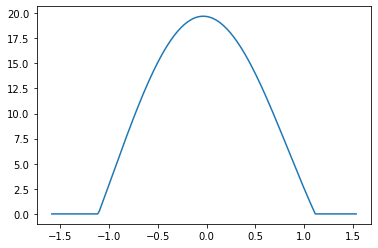

In [235]:
real_rates_7 = torch.relu(
    real_rates_4 @ A_4  +
    real_rates_5 @ A_5  +
    real_rates_6 @ A_6  
)

plt.plot(all_bins_new * (2 * math.pi) / (num_bins), real_rates_7[0])

Finally, we can compare these rates to the basis set we generated

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


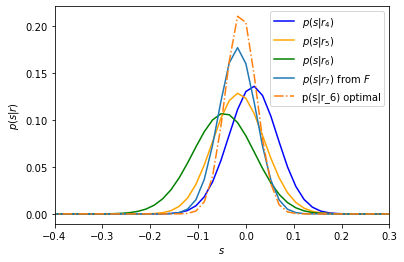

In [236]:
fig, axes = plt.subplots(1)

axes.set_ylabel('$p(s|r)$')
axes.set_xlabel('$s$')
axes.legend()

axes.set_xlim(-0.4, 0.3)

axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_4, color='blue', label = '$p(s|r_4)$')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_5, color='orange', label = '$p(s|r_5)$')
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_6, color='green', label = '$p(s|r_6)$')


poisson_llh_7 = basis_population.rate_loglikelihoods(real_rates_7, all_possible_responses_basis, duration).sum(-1)
posterior_7 = normalise_log_likelihoods(poisson_llh_7)
axes.plot(all_bins_new * (2 * math.pi) / (num_bins), posterior_7, label = '$p(s|r_7)$ from $F$')

target_posterior_std_7 = (posterior_std_4**-2 + posterior_std_5**-2 + posterior_std_6**-2) ** -0.5
target_posterior_mean_7 = (target_posterior_std_7**2) * (
    posterior_mean_4 * posterior_std_4**-2 +
    posterior_mean_5 * posterior_std_5**-2 +
    posterior_mean_6 * posterior_std_6**-2
)

target_posterior_7 = gaussian_pdf(all_bins_new, target_posterior_std_7, target_posterior_mean_7)

axes.plot(all_bins_new * (2 * math.pi) / (num_bins), target_posterior_7, linestyle = '-.', label = 'p(s|r_6) optimal')

axes.legend()

TODO: Again - these should match much better, also I tuned reg to look nice and it still doesn't!